# Gesture Recognition
Objective is to build a 3D convolution model to detect 5 gestures correctly

In [1]:
import numpy as np
import os
import datetime
import os
from imageio import imread
from skimage.transform import resize
from tensorflow import keras
import tensorflow as tf
import random as rn
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-02-06 08:19:01.719967: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-06 08:19:01.767224: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 08:19:02.022156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 08:19:02.022248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register 

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

Read the folder namesfor training and validation. Note that you set batch_size also here for efficient usage of GPU

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 39

In [4]:
def get_image_spec(nb_frames, x, y):
    return [np.round(np.linspace(0, 29, nb_frames)).astype('int'), x, y]


img_specs = get_image_spec(20, 100, 100)

## Generator

In this  we are going to pre-process the images as the images are of different dimensions. 

In [5]:
def get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs):
    x, y, z = len(img_specs[0]), img_specs[1], img_specs[2]
    img_idx = img_specs[0]  
    batch_data = np.zeros((batch_size, x, y, z, 3)) 
    batch_labels = np.zeros((batch_size, 5))  
    
    for folder in range(batch_size):  
        imgs = os.listdir('{0}/{1}'.format(source_path, t[folder + (batch * batch_size)].split(';')[0])) 
        
        for idx, item in enumerate(img_idx):  
            image = imread('{0}/{1}/{2}'.format(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])).astype(np.float32)
            
            
            if image.shape[0] != image.shape[1]:
                image = image[:120, 20:140]
            image = resize(image, (y, z))
            
            batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255.0  
            batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255.0  
            batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255.0  
        
        batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
    
    return batch_data, batch_labels


def generator(source_path, folder_list, batch_size, img_specs=img_specs):
    print(f"Source Path: {source_path}; Batch Size: {batch_size}")
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list) / batch_size)
        for batch in range(num_batches):  
            yield get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs)  
            
        if len(folder_list) % batch_size != 0:
            batch_size = len(folder_list) % batch_size
            yield get_batch_labels_and_data(source_path, t, batch, batch_size, img_specs)  

Here a video is represented in the generator as (no.of images, height, width, no. of channels)

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print(f"No. of training sets: {num_train_sequences}")
num_val_sequences = len(val_doc)
print(f"No of validation sets: {num_val_sequences}")
num_epochs = 20 # choose the number of epochs
print(f"No. of  epcohs: {num_epochs}")

No. of training sets: 663
No of validation sets: 100
No. of  epcohs: 20


## Model
Make a model with different features provided by Keras. Remember that the last layer is softmax. The model is designed to give good accuracy

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling3D
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling3D, MaxPooling2D
from tensorflow.keras.layers import TimeDistributed

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import optimizers

In [8]:
input_shape = (len(img_specs[0]), img_specs[1], img_specs[2], 3)

### Experiment 1:  Model - 1:

In [9]:
# write your model here

# model 1 -- base model

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))

# model.add(Conv3D(63, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20 <br />
Train accuracy: 0.20 and Validation accuracy: 0.41 <br />
As the the model is not able to learn, need to add add more layers

### Experiment 2: Model - 2 & Model 3

In [10]:
# model 2 -- increasing the number of layers

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(64, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
        
# model.add(Conv3D(128, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(63, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

# model 3 -- reducing the number of parameters

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Both models are having 20 Epochs.
Train accuracy of .61 and .97
Test accuracy .75 and .83

As the model 2 train accuracy is sub-par and model 2 seems to be overfittung lets try with reduced no. of parameters

### Experiment 3: Model - 4

In [11]:
# model 4 -- reducing even more trainable parameters

# model = Sequential()

# model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(32, (3, 3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, (2, 2, 2), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20
Train accuracuy: 0.17 and Validation accuracy: 0.5
Poor train efficiency, seems to be underfitting. Need to try by increasing the Epochs

### Experiment 4: Model - 5

In [12]:
# model - 5 -- Increasing the number of parameters

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40
Training accuracy: 1.00 and Validation accuracy: 0.91
Model is overfitting

### Experiment 5: Model - 6 and Model -7

In [13]:
# model - 6 -- Reducing number of parameters and re-introducing dropout layers

# model = Sequential()

# model.add(Conv3D(16, (5, 5, 5), activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D((2, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Conv3D(32, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Conv3D(64, (3, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(5, activation='softmax'))

# model - 7 -- Increasing the number of Droupout layers and replaing Flatten with GlobalAveragePooling3D

# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40 
Training accuracy: 0.99 for both models and test accuracy of 1.00 and .91 respectively
Model 6 seems to be overiftting. Model - 7 even though its giving good results, need to attempt how close can we reach to 1.0 accuracy

### Experiment 6 - Model - 8

In [14]:
# model - 8 -- CNN with LSTM, reducing the number of epochs to 20

# model = Sequential()

# model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
# model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(64))
# model.add(Dropout(0.25))
        
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.25))
        
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 20
Train accuracy: 0.50 and Validation accuracy: 0.66
The accuracy of the model is sub-par. Trying a different architecture -> Conv2D with GRU

### Experiment 7 - Model - 9

In [15]:
# model - 9 -- TimeDistributed Conv2D + GRU

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(63, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='relu'))

Number of Epochs: 40
Train accuracy: 0.96 and Validation accuracy: 0.81
The difference between the train and validation accuracy is significant, adding Dropout layers to the model.

### Experiment 8 - Model - 10 and Model -11

In [16]:
# model - 10 -- TimeDistributed Conv2D + GRU

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(63, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='relu'))

# model - 11 -- TimeDistributed Conv2D with GlobalAvreagePooling3D

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D(2, 2)))
# model.add(BatchNormalization())

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

Number of Epochs: 40
Train accuracy: 0.86 and 0.99 and test accuracy: 0.58 and .91
Introduce dropout layer to Model-10

### Model - 12 - Final Model

In [17]:
model = Sequential()

model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Number of Epochs: 50
Train accuracy: 0.93 and Test Accuracy = 0.91
Both the train and validation accuracy are in the range of .9 

Compile the model 

In [18]:
optimiser = optimizers.Adam(lr=0.01)  # write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 98, 98, 32)    896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 49, 49, 32)    0         
 stributed)                                                      
                                                                 
 batch_normalization (Batch  (None, 20, 49, 49, 32)    128       
 Normalization)                                                  
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 47, 47, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 23, 23, 64)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init_{}/'.format(str(curr_dt_time).replace(' ', '').replace(':', '_'))
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)  # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fit the model

In [22]:
num_epochs =50
print(f"Epochs: {num_epochs}")

Epochs: 50


In [23]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_3427/534713445.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread('{0}/{1}/{2}'.format(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])).astype(np.float32)


Source Path: Project_data/train; Batch Size: 39
Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 1.7855 - categorical_accuracy: 0.3876Source Path: Project_data/val; Batch Size: 39


2024-02-06 08:20:47.133421: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 93600780 bytes after encountering the first element of size 93600780 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 1: saving model to model_init_2024-02-0608_19_04.003306/model-00001-1.78552-0.38763-1.60958-0.21000.h5
17/17 [==============================] - 110s 7s/step - loss: 1.7855 - categorical_accuracy: 0.3876 - val_loss: 1.6096 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/50


/home/jenny/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 1.3540 - categorical_accuracy: 0.5264
Epoch 2: saving model to model_init_2024-02-0608_19_04.003306/model-00002-1.35405-0.52640-1.59697-0.25758.h5
17/17 [==============================] - 100s 6s/step - loss: 1.3540 - categorical_accuracy: 0.5264 - val_loss: 1.5970 - val_categorical_accuracy: 0.2576 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 1.2542 - categorical_accuracy: 0.5656
Epoch 3: saving model to model_init_2024-02-0608_19_04.003306/model-00003-1.25421-0.56561-1.79397-0.19444.h5
17/17 [==============================] - 96s 6s/step - loss: 1.2542 - categorical_accuracy: 0.5656 - val_loss: 1.7940 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 1.0161 - categorical_accuracy: 0.6244
Epoch 4: saving model to model_init_2024-02-0608_19_04.003306/model-00004-1.01605-0.62443-1.64056-0.25000.h5
17/17 [==========================

17/17 [==============================] - 95s 6s/step - loss: 0.2979 - categorical_accuracy: 0.8869 - val_loss: 1.0008 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 24/50
17/17 [==============================] - ETA: 0s - loss: 0.2935 - categorical_accuracy: 0.8869
Epoch 24: saving model to model_init_2024-02-0608_19_04.003306/model-00024-0.29347-0.88688-3.20745-0.00000.h5
17/17 [==============================] - 94s 6s/step - loss: 0.2935 - categorical_accuracy: 0.8869 - val_loss: 3.2074 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 25/50
17/17 [==============================] - ETA: 0s - loss: 0.3314 - categorical_accuracy: 0.8748
Epoch 25: saving model to model_init_2024-02-0608_19_04.003306/model-00025-0.33141-0.87481-1.79436-0.41667.h5
17/17 [==============================] - 95s 6s/step - loss: 0.3314 - categorical_accuracy: 0.8748 - val_loss: 1.7944 - val_categorical_accuracy: 0.4167 - lr: 0.0010
Epoch 26/50
17/17 [==============================] - ETA: 0s - l

Epoch 45/50
17/17 [==============================] - ETA: 0s - loss: 0.1900 - categorical_accuracy: 0.9321
Epoch 45: saving model to model_init_2024-02-0608_19_04.003306/model-00045-0.19003-0.93213-0.99155-0.66667.h5
17/17 [==============================] - 95s 6s/step - loss: 0.1900 - categorical_accuracy: 0.9321 - val_loss: 0.9915 - val_categorical_accuracy: 0.6667 - lr: 0.0010
Epoch 46/50
17/17 [==============================] - ETA: 0s - loss: 0.1316 - categorical_accuracy: 0.9487
Epoch 46: saving model to model_init_2024-02-0608_19_04.003306/model-00046-0.13156-0.94872-1.80554-0.58333.h5
17/17 [==============================] - 95s 6s/step - loss: 0.1316 - categorical_accuracy: 0.9487 - val_loss: 1.8055 - val_categorical_accuracy: 0.5833 - lr: 0.0010
Epoch 47/50
17/17 [==============================] - ETA: 0s - loss: 0.1434 - categorical_accuracy: 0.9457
Epoch 47: saving model to model_init_2024-02-0608_19_04.003306/model-00047-0.14340-0.94570-4.08890-0.41667.h5
17/17 [==========

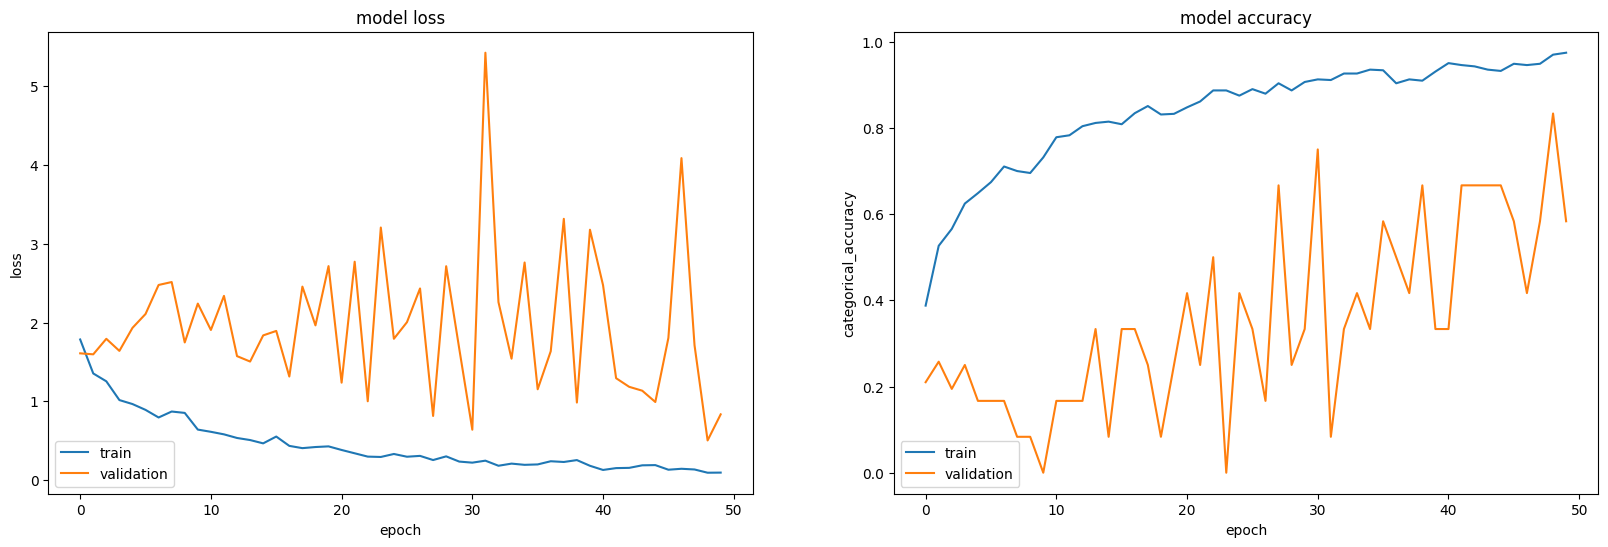

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')